In [ ]:
!pip install -U sentence-transformers
!pip install bertopic
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 39.2 MB/s eta 0:00:00


# Clustering word embeddings

In [ ]:
import re
from collections import Counter

import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from stop_words import get_stop_words

In [ ]:
m = SentenceTransformer("shibing624/text2vec-base-multilingual")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/496 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
df = pd.read_csv("/content/parallel_data_clean.csv")

sentences = list(df["source"])
sentences[:10]

['Те мальчики не выполнят задание в назначенный срок.',
 'Бегая к берегу озера пришла, к воде подбежала. ',
 'Вода прибывала на глазах ',
 'Обнюхивает нас, живыми на кладбище уносит. ',
 'Мы никогда не забудем этого честного человека.',
 'Невод зацепился по среди реки ',
 'Черех дорогу перелетел рябчик. ',
 'Едет на оленьей упряжке, слышит, кто-то напротив кладбища плачет.',
 'Вот эта хорошая шуба, вообще как белый снег. ',
 'Выкопал могилу - такая красивая девушка.']

In [ ]:
!pip install stop-words
!pip install pymystem3

In [ ]:
df = pd.read_csv("/content/parallel_data_clean.csv", index_col=0)


russian_stopwords = get_stop_words("russian")
print(len(russian_stopwords))


mystem = Mystem()


nltk.download("stopwords")
nltk_stopwords = set(stopwords.words("russian"))
stop_words_pkg = set(get_stop_words("russian"))
all_stopwords = nltk_stopwords | stop_words_pkg
print(f"Количество стоп-слов: {len(all_stopwords)}")


def lemmatize_and_remove_stopwords(text):
    lemmas = mystem.lemmatize(text)
    lemmas = [l for l in lemmas if l.isalpha()]
    lemmas_clean = [l for l in lemmas if l.lower() not in all_stopwords]
    return " ".join(lemmas_clean)


df["source_word_count"] = df["source"].apply(lambda x: len(x.split()))
df["source_clean"] = df["source"].apply(lemmatize_and_remove_stopwords)
df["source_clean_word_count"] = df["source_clean"].apply(
    lambda x: len(x.split())
)

df[["source_word_count", "source_clean_word_count"]].describe()


sentences = list(df["source_clean"])
sentences[:10]

In [ ]:
sentence_embeddings = m.encode(sentences)
print("Sentence embeddings:")
print(sentence_embeddings)

Sentence embeddings:
[[ 0.06781141  0.29819176 -0.10861278 ... -0.09393319 -0.05198461
   0.12225608]
 [ 0.41907024  0.4034492   0.03938688 ... -0.02934923 -0.07208434
   0.307042  ]
 [ 0.15343782  0.1703744   0.11813653 ... -0.03212215 -0.09258153
   0.3155696 ]
 ...
 [ 0.26686552  0.15567201 -0.09933108 ...  0.13723724  0.11694469
   0.09635074]
 [ 0.06182298  0.11824062 -0.06858357 ...  0.06060421 -0.00975633
   0.19946545]
 [-0.10382073 -0.11224394 -0.02611089 ... -0.09941863  0.26358348
   0.20977274]]


In [ ]:
df["embedding"] = sentence_embeddings.tolist()

In [ ]:
def preprocess_and_tokenize(text):
    # Remove punctuation and lower the text
    text = re.sub(r"[^\w\s]", "", text.lower())
    return word_tokenize(text)

In [ ]:
def get_top_words(cluster_df, n=10):
    # Flatten the list of tokens for the cluster and filter words longer than 3 characters
    russian_stopwords = set(stopwords.words("russian"))
    all_words = [
        word
        for tokens in cluster_df["tokens"]
        for word in tokens
        if len(word) > 3 and word not in russian_stopwords
    ]
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

In [ ]:
nltk.download("punkt_tab")
df["tokens"] = df["source"].apply(preprocess_and_tokenize)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
nltk.download("stopwords")

c_v = []
num_clusters = [10, 20, 30, 40, 50]  # 60, 70, 80, 90, 100]
for n in num_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10).fit(
        sentence_embeddings
    )
    df["cluster"] = kmeans.labels_
    clustered_words = {}
    print("Number of clusters: ", n)
    for cluster in range(n):
        cluster_df = df[df["cluster"] == cluster]
        top_words = get_top_words(cluster_df, n=25)
        clustered_words[cluster] = [word for word, _ in top_words]
    print(clustered_words)

    dictionary = gensim.corpora.Dictionary(clustered_words.values())
    corpus = [dictionary.doc2bow(words) for words in clustered_words.values()]

    coherence_model = CoherenceModel(
        topics=clustered_words.values(),
        texts=[list(clustered_words[cluster]) for cluster in clustered_words],
        dictionary=dictionary,
        coherence="c_v",
    )

    coherence_score = coherence_model.get_coherence()
    c_v.append(coherence_score)
    print(f"Coherence Score for {n} clusters: {coherence_score}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Number of clusters:  10
{0: ['дети', 'детей', 'люди', 'людей', 'очень', 'туда', 'вместе', 'манси', 'школе', 'детям', 'время', 'песни', 'пусть', 'разные', 'язык', 'женщины', 'ханты', 'языке', 'день', 'году', 'детьми', 'стали', 'дома', 'человек', 'некоторые'], 1: ['люди', 'году', 'пусть', 'будут', 'работать', 'людей', 'работу', 'очень', 'деньги', 'дальше', 'года', 'вместе', 'туда', 'человек', 'каждый', 'рублей', 'дело', 'день', 'дела', 'работает', 'работают', 'округе', 'денег', 'людям', 'время'], 2: ['году', 'городе', 'района', 'года', 'россии', 'деревне', 'работает', 'манси', 'языке', 'ханты', 'язык', 'наталья', 'люди', 'город', 'очень', 'города', 'людей', 'женщина', 'районе', 'сказал', 'деревни', 'родился', 'время', 'туда', 'сказала'], 3: ['зверя', 'лесу', 'оленей', 'говорит', 'собака', 'зверь', 'зверей', 'очень', 'медведь', 'оленя', 'собаки', 'мышонок', 'мясо', 'хвост', 'животных', 'волк', 'день', 'лиса', 'охотник', 'смотрит', 'глаза', 'рыбу', 'олени', 'свой', 'олень'], 4: ['говорит',

Text(0, 0.5, 'Coherence score')

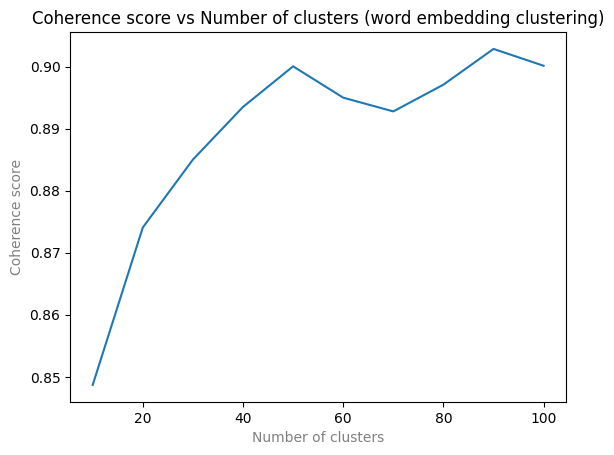

In [ ]:
plt.plot(num_clusters, c_v)
plt.title("Coherence score vs Number of clusters (word embedding clustering)")
plt.xlabel("Number of clusters", color="gray")
plt.ylabel("Coherence score", color="gray")

In [ ]:
cluster_sizes = pd.Series(kmeans.labels_).value_counts().sort_index()
plt.figure(figsize=(10, 6))
cluster_sizes.plot(kind="bar")
plt.title("Размер кластеров")
plt.xlabel("Кластер")
plt.ylabel("Количество предложений")
plt.xticks(rotation=0)
plt.show()

In [ ]:
top_words_per_cluster = {}
for cluster in range(num_clusters):
    cluster_df = df[df["cluster"] == cluster]
    top_words_per_cluster[cluster] = get_top_words(cluster_df, n=10)

# Display the most used words in each cluster
for cluster, words in top_words_per_cluster.items():
    print(f"Cluster {cluster}: {words}")

In [ ]:
from IPython.display import FileLink

FileLink("data_w_clusters.csv")

## BERTopic

In [ ]:
from bertopic import BERTopic

model = BERTopic(language="multilingual")
topics, probs = model.fit_transform(sentences)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
topic_words = model.get_topic_info()

# Create a dictionary of topics with their words
topics_dict = {}
for topic in range(len(topic_words)):
    words = model.get_topic(topic)
    if not words:
        continue
    topics_dict[topic] = [word for word, _ in words]

texts = [sentence.split() for sentence in sentences]
dictionary = gensim.corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Calculate coherence score
coherence_model = CoherenceModel(
    topics=topics_dict.values(),
    texts=texts,
    dictionary=dictionary,
    coherence="c_v",
)
coherence_score = coherence_model.get_coherence()

print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.2763341188398589


In [ ]:
topics_dict

{0: ['не',
  'ничего',
  'никогда',
  'нет',
  'никто',
  'ни',
  'никого',
  'нельзя',
  'больше',
  'молча'],
 1: ['лес',
  'лесу',
  'дерево',
  'дерева',
  'леса',
  'деревья',
  'деревьев',
  'деревьями',
  'лесной',
  'дрова'],
 2: ['ма', 'та', 'ос', 'ла', 'хо', 'гыт', 'ва', 'са', 'па', 'нэ'],
 3: ['женщины',
  'женщин',
  'девушка',
  'она',
  'женщина',
  'её',
  'девочка',
  'женщиной',
  'женщину',
  'неё'],
 4: ['рыбу',
  'рыбы',
  'ловить',
  'рыба',
  'рыбой',
  'рыбалку',
  'ловят',
  'рыбачить',
  'рыбаки',
  'рыбаком'],
 5: ['шить',
  'одежду',
  'платья',
  'платье',
  'одежды',
  'шила',
  'бисера',
  'шьют',
  'мансийские',
  'сшила'],
 6: ['лодку',
  'лодки',
  'лодке',
  'лодка',
  'лодках',
  'весло',
  'лодок',
  'веслом',
  'сел',
  'деревянные'],
 7: ['едой',
  'еды',
  'обской',
  'озёрной',
  'пищу',
  'поесть',
  'еду',
  'пищи',
  'едят',
  'еда'],
 8: ['человек',
  'тысяч',
  'более',
  'двадцать',
  '200',
  'около',
  'тридцать',
  'тысячи',
  '50',
  'о

In [ ]:
from gensim.models import LdaModel

In [ ]:
# Tokenize the sentences
tokenized_sentences = [
    preprocess_and_tokenize(sentence) for sentence in sentences
]

# Remove stopwords
russian_stopwords = set(stopwords.words("russian"))
filtered_sentences = [
    [
        word
        for word in tokens
        if word not in russian_stopwords and len(word) > 3
    ]
    for tokens in tokenized_sentences
]

# Create a dictionary and corpus for LDA
dictionary = gensim.corpora.Dictionary(filtered_sentences)
corpus = [dictionary.doc2bow(text) for text in filtered_sentences]

c_v = []
num_clusters = [10, 20, 30, 40, 50]  # , 60, 70, 80, 90, 100]
for n in num_clusters:
    print("Number of clusters: ", n)
    lda_model = LdaModel(corpus, num_topics=n, id2word=dictionary, passes=15)

    # Print the topics
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic {idx}: {topic}")

    # Calculate coherence score
    coherence_model_lda = CoherenceModel(
        model=lda_model,
        texts=filtered_sentences,
        dictionary=dictionary,
        coherence="c_v",
    )
    coherence_lda = coherence_model_lda.get_coherence()
    print(f"Coherence Score: {coherence_lda}")
    c_v.append(coherence_lda)

Number of clusters:  10
Topic 0: 0.026*"работает" + 0.021*"женщина" + 0.020*"будут" + 0.018*"каждый" + 0.016*"дома" + 0.016*"мама" + 0.015*"школе" + 0.013*"могут" + 0.012*"дела" + 0.012*"районе"
Topic 1: 0.031*"работать" + 0.029*"поэтому" + 0.027*"языке" + 0.017*"работы" + 0.016*"город" + 0.013*"говорят" + 0.011*"посёлке" + 0.010*"приезжали" + 0.010*"сначала" + 0.010*"знают"
Topic 2: 0.024*"очень" + 0.022*"деревне" + 0.017*"затем" + 0.016*"день" + 0.015*"района" + 0.013*"работают" + 0.013*"деревни" + 0.012*"жить" + 0.011*"люди" + 0.011*"родился"
Topic 3: 0.040*"вместе" + 0.023*"говорит" + 0.021*"другие" + 0.019*"также" + 0.018*"вещи" + 0.018*"отец" + 0.017*"нужно" + 0.013*"долго" + 0.012*"работающие" + 0.011*"народов"
Topic 4: 0.031*"детей" + 0.031*"человек" + 0.021*"живут" + 0.019*"разные" + 0.012*"живет" + 0.011*"сразу" + 0.011*"собой" + 0.010*"своих" + 0.010*"коренных" + 0.010*"рассказы"
Topic 5: 0.035*"туда" + 0.032*"время" + 0.028*"городе" + 0.021*"дальше" + 0.018*"сказал" + 0.017

Text(0, 0.5, 'Coherence score')

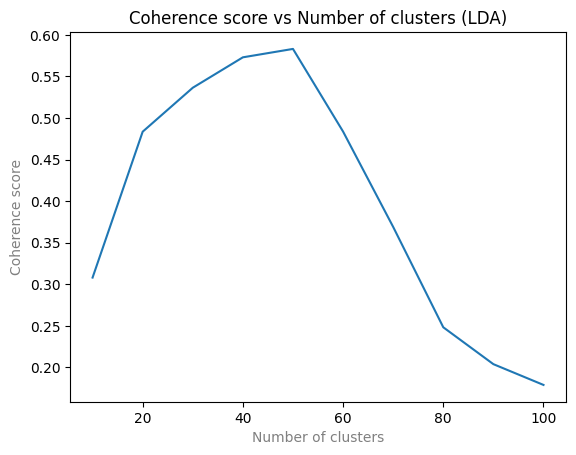

In [ ]:
plt.plot(num_clusters, c_v)
plt.title("Coherence score vs Number of clusters (LDA)")
plt.xlabel("Number of clusters", color="gray")
plt.ylabel("Coherence score", color="gray")